## Packages

In [1]:

import matplotlib.pyplot as plt
from numpy import full, empty, floor, linspace, eye
from sympy import Matrix, Symbol, lambdify, shape

from helper_functions import (
    pmns_matrix,
    hamiltonian,
    calculate_probability,
    make_symbols,
    get_constants,
)

## Parameters
Adjustable values

In [2]:
neutrinos = 2 #Number of neutrino flavor states

ticks = 50 #How many intervals will energy be divided into

steps = 50 #How many intervals will distance be divided into

distance = 100 #Total distance traveled by Neutrino

#Range of energies to analyze
energy_range_start = 3*10**(-3)
energy_range_end = 10**(-2)

#(0,1,2,3) -> Electron, muon, tau, and sterile neutrino flavor states, respectively
starting_state = 1
ending_state = 0
potential_range = False
potentials = [-0.02,-0.01,0,0.01,0.02]

## probability_plotter

# Generates plots of energy vs probability
# Params:
 H: matrix for hamiltonian
 
 Constants: dictionary containing values for theta angles, phase angles, and neutrino masses
 energy_values: range of energies to plot
 
 potential_values: list of potentials at different distances: list must have length of distance or 1 with potential_range = False, length of any size for potential_range = True

 energy_values: range of energies to plot
 
 distance: total length traveled by neutrino
 
 nu_I: Starting neutrino flavor state
 
 nu_F: Detected neutrino flavor state
 
 steps: The number of intervals distance will be divided into
 
 symbols: dictionary containing symbols for theta angles, phase angles, neutrino masses, energy, and potential
 
 potential_range: True for plotting results of multiple constant potentials, false for plotting results of one non-constant potential
 
# Returns:
 None

In [3]:


def probability_plotter(H:Matrix,constants:dict,energy_values:list,potential_values:list,distance:int,nu_I:list,nu_F:list,steps, symbols, potential_range:bool=False) -> None:
    
    lam_H = lambdify([symbols['Energy'],symbols['A']],H)
    hamiltonian_size = shape(H)[0]    
    step_size = distance / steps

    y = [] #array containing probabilities of the neutrino at energy[i]
    
    if not potential_range:
        for energy_value in energy_values: #Iterates over all energy values to calculate a curve for probability as a function of energy
            y.append(calculate_probability(lam_H,energy_value,full(steps,potential_values),step_size,nu_I,nu_F,steps))
    else:
        ylist = empty((len(potential_values), len(energy_values)))
    
        for j, energy_value in enumerate(energy_values):#Iterates over all energy values to calculate a curve for probability as a function of energy
            i = 0
            for i, potential_value in enumerate(potential_values):#Iterates over each potential to calculate a different curve for probability as a function of energy depending on potential
                ylist[i,j] = calculate_probability(lam_H,energy_value,[potential_value]*steps,step_size,nu_I,nu_F,steps)
                
            
        y = ylist[int(floor(len(potential_values)/2)),:]

    fig, ax = plt.subplots(1,1,figsize = (12,4))
    axs = [ax]

    xlabel = r"$Energy$"
    ylabel = r"$Probability$"
    
    if potential_range == True: #Plots every curve created of potential_range = True
        
        #axs[0].plot(energy_values,[y for y in ylist.transpose()])
        for curve in ylist:
            axs[0].plot(energy_values, curve)
        
        potential_range_label = [p for p in potential_values]
        leg2 = axs[0].legend(potential_range_label,loc = "upper right")
        axs[0].add_artist(leg2)
    else: #else, plots the single curve created
        axs[0].plot(energy_values,y)        
      
    axs[0].legend([str(hamiltonian_size) + "x" + str(hamiltonian_size) + " Hamiltonian"],loc = "upper left")
    
    axs[0].set_xlabel(xlabel+" (GeV)")
    axs[0].set_ylabel(ylabel)
    axs[0].set_title(ylabel + " vs " + xlabel)

## start
# Initializes program
# Params:
V: matrix potential for hamiltonian, should contain one symbol with 0s elsewhere

Constants: dictionary containing values for theta angles, phase angles, and neutrino masses

energy_values: range of energies to plot

potential_values: list of potentials at different distances: list must have length of distance or 1 with potential_range = False, length of any size for potential_range = True

distance: total length traveled by neutrino

nu_I: Starting neutrino flavor state

nu_F: Detected neutrino flavor state

steps: The number of intervals distance will be divided into

symbols: dictionary containing symbols for theta angles, phase angles, neutrino masses, energy, and potential

potential_range: True for plotting results of multiple constant potentials, false for plotting results of one non-constant potential
# Returns:
None

In [4]:


def start(V:Matrix,constants:dict,energy_values:list,potential_values:list,distance:int,nu_I:list,nu_F:list,steps:int,symbols:dict,potential_range:bool =False) -> None:

    #Asserts check for correct inputs
    
    assert(isinstance(V,Matrix)
          ), 'V must be of type Matrix'
    size = shape(V)[0]
    assert (isinstance(constants, dict)
           ), 'constants must be of type dict, create constants using get_constants'
    assert (isinstance(energy_values, list)
           ), 'energy range must be a list. To check a single energy value, input [value]'
    assert(isinstance(potential_values, list)
          ), 'potential values must be a list. to use a constant value with potential_values == False, input [value]'
    #Checks for correct dimensions of potential_values
    assert ((len(potential_values) ==1 or len(potential_values) == distance) or potential_range
           ), 'must have potential_range or len(potential_values) in (1,distance)'
    assert(isinstance(distance, int)
          ), 'distance must be an integer'
    assert(distance > 0
          ), 'distance must be greater than 0'
    assert(isinstance(nu_I, list) and len(nu_I) >= size
          ), 'nu_I must be a list of at least length ' + str(size)
    assert(isinstance(nu_I, list) and len(nu_F) >= size
          ), 'nu_F must be a list of at least length ' + str(size)
    assert(isinstance(symbols, dict)
          ), 'symbols must be of type dict, create symbols with make_symbols'
    assert(isinstance(potential_range, bool)
          ), 'potential_range must be a boolean'

    #Trims flavor states to match size of hamiltonian
    nu_I = nu_I[0:size]
    nu_F = nu_F[0:size]

    #https://en.wikipedia.org/wiki/Pontecorvo%E2%80%93Maki%E2%80%93Nakagawa%E2%80%93Sakata_matrix
    U = pmns_matrix(size,symbols)# Generates pmns matrix
    H = hamiltonian(U,V,symbols)# Uses pmns matrix to generate hamiltonian for the neutrino

    H = H.subs(constants) #Subs symbolic variables in for constants to allow for fast calculations later
    probability_plotter(H,constants,energy_values,potential_values,distance,nu_I,nu_F,steps, symbols, potential_range)
    

## Execution

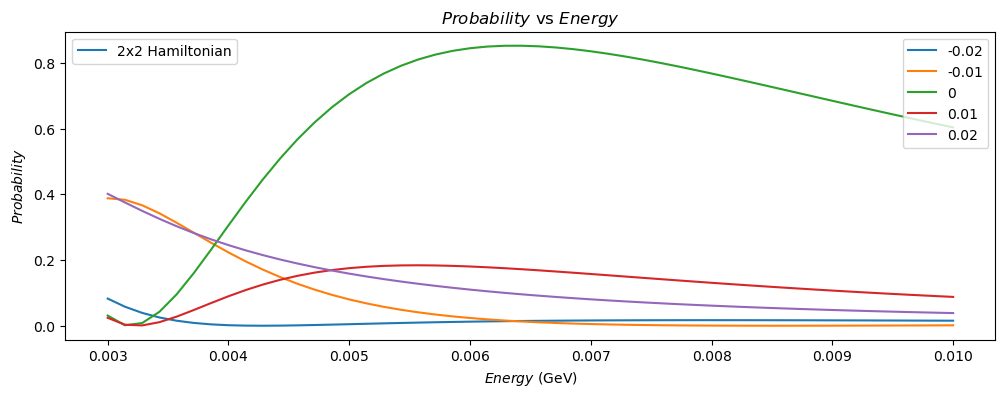

In [5]:

#Starting and ending neutrino states in the flavor basis
nu_I = eye(4)[starting_state].tolist()
nu_F = eye(4)[ending_state].tolist()

energy_range = list(linspace(3*10**(-3),10**(-2),num =ticks))

#Generates symbolic variables to use for quick calculations
symbols = make_symbols() 

#Current estimations can be found on nuFit: http://www.nu-fit.org/?q=node/8
constants = get_constants(symbols)

A = symbols['A'] #A: symbol for potential
if neutrinos == 2:
    V = Matrix([[A,0],[0,0]]) #2x2 case with potential only affecting electron neutrino
elif neutrinos == 3:
    V = Matrix([[A,0,0],[0,0,0],[0,0,0]]) #3x3 case with potential only affecting electron neutrino
elif neutrinos == 4:
    V = Matrix([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,A]]) #4x4 case with potential only affecting sterile neutrino

start(V,constants,energy_range,potentials,distance,nu_I,nu_F,steps,symbols,potential_range)